In [15]:
# COMENZAMOS CON EL ENTRENAMIENTO DE LOS MODELOSfrom sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sys import path
sys.path.append('C:\\Users\\Laura\\Desktop\\Nueva carpeta\\Code\\util')

from funciones import graficos_conf_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix,recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pickle


In [16]:
# IMPORTAMOS EL CSV YA LIMPIO .
# LO VAMOS A DIVIDIR EN DOS, UNA PARTE PARA EL ENTRENAMIENTO-PREDICCIONES Y OTRA PARTE PARA EL TEST, COMO SI DE DATOS REALES SE TRATARAN


data_train = pd.read_csv('../Data/Processed/data_processed.csv', index_col=0)

data_train = data_train.iloc[:int(data_train.shape[0]*60/100), :]
data_test = data_train.iloc[int(data_train.shape[0]*60/100) : , :]

In [17]:
# DIVIDIMOS EN DATA_TRAIN EN TRAIN Y TEST


X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns=['Target','Anxiety','Stress'], axis=1), data_train.Target, random_state=0, test_size=0.20, shuffle=True)



LOGISTIC REGRESION

In [18]:
# CREACION DE PIPELINE INICIAL.
# HACEMOS UN GRIDSEARCH CON CROSS VALIDATIION
# LO INSTANCIAMOS
model_lr = Pipeline (steps = [
                     ('scaler', MinMaxScaler()),
                     ('lr', LogisticRegression())]
                    ) 


params = {'lr__penalty' : ['l1','l2','elasticnet'],
              'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'lr__max_iter': [100,200,300,400,500],
              'lr__C': [0.8,0.5,0.3]
            }


logistic_gtc = GridSearchCV(model_lr, params, cv=5, scoring='accuracy')
logistic_gtc.fit(X_train, y_train)

C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
525 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.8, 0.5, 0.3],
                         'lr__max_iter': [100, 200, 300, 400, 500],
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                        'sag']},
             scoring='accuracy')

In [19]:
# SACAMOS LOS MEJORES PARÁMETROS PARA ENTRENAR EL MODELO

print (logistic_gtc.best_params_)
print (logistic_gtc.best_estimator_)

{'lr__C': 0.8, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lr', LogisticRegression(C=0.8, solver='liblinear'))])


In [20]:
#CREAMOS UN NUEVO PIPELINE CON EL RESULTADO MEJOR RESULTADO DEL GRIDSEARCH
model_lr_V0 = logistic_gtc.best_estimator_

In [21]:
# ENTRENAMOS EL MODELO Y SACAMOS LAS PREDICCIONES
model_lr_V0
model_lr_V0.fit(X_train,y_train)
y_predi = model_lr_V0.predict(X_test)

In [22]:
# PASAMOS LAS METRICAS A UN DATAFRAME MENO LA CONFUSION MATRIX
df_scores = {'log_re_data_train' :[recall_score(y_test,y_predi), roc_auc_score(y_test,y_predi),  accuracy_score(y_test, y_predi), f1_score(y_test, y_predi)]}
df_scores = pd.DataFrame(df_scores, index=['Recall','Auc','Accuracy', 'F1_score'])
df_scores

In [23]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_train = confusion_matrix(y_test, y_predi)

In [24]:
# GUARDAMOS EL MODELO

with open('../Model/model_logist_V1', 'wb') as archivo_salida:
    pickle.dump(model_lr_V0, archivo_salida)


In [25]:
# PROBAMOS EL MODELO CON LOS DATOS RESERVADOS PARA VER COMO GENERALIZA

X = data_test.drop(columns=['Target','Anxiety','Stress'], axis=1)
y= data_test.Target

with open('../Model/model_logist_V1', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [26]:
# PASAMOS LAS METRICAS A UN DATAFRAM
df_scores['log_re_test'] =[recall_score(y,loaded_model.predict(X)), roc_auc_score(y,loaded_model.predict(X)), accuracy_score(y, loaded_model.predict(X)), f1_score(y, loaded_model.predict(X))]
df_scores.to_csv('../Model/scores_models_Accu.csv')
df_scores

In [27]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_test = confusion_matrix(y,loaded_model.predict(X))

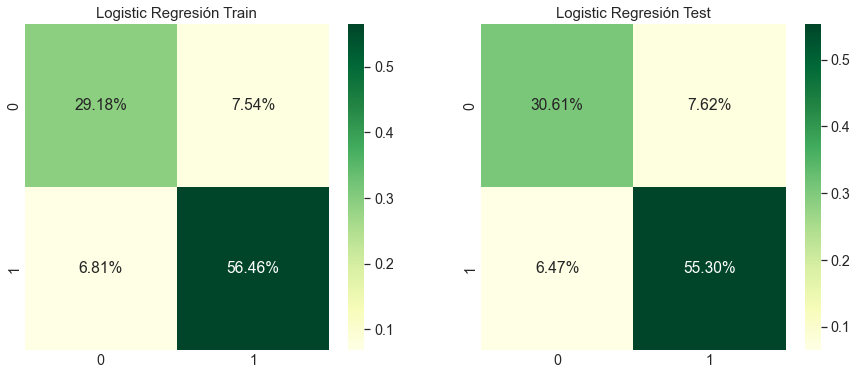

In [28]:
graf_lg_A_matriz = plt.figure(figsize=(15,6))

plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,1)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_train,'Logistic Regresión Train')

plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,2)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_test,'Logistic Regresión Test')

graf_lg_A_matriz.savefig ('../util/Graficos/graf_lg_A_matriz.png')